# STATS 370 Final project

In [5]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

In [6]:
%load_ext autoreload
%autoreload 2

from plot_utils import plot_dist, plot_marginals, plot_acorr, set_plt_settings, RESULTS_PATH
from dist_utils import prob_post, value_mh_cand, prob_mh_cand
from dist_utils import val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam
from dist_utils import prob_HMC
from dist_utils import val_is_cand, weight_is_cand
from mc_utils import MH, leapfrog, HMC

set_plt_settings()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# constants
THETA_LABELS = ['ss', 'tau', 'mu1', 'mu2', 'gam1', 'gam2']

In [8]:
# read in data
data = np.genfromtxt('data.csv', delimiter=',', skip_header=1, usecols=(1,2,3))
groups = torch.tensor(data[:,0].astype(int))
Y = torch.tensor(data[:, 1:], requires_grad=True)

# Metropolis Hasting
### Grid search for best hyperparameters

In [9]:
# grid search
# vary variances of proposal distributions to i) increase acceptance probability and ii) decrease acorr
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
burn_in = 100
T = 500 + burn_in
lag_steps = [10, 50]
acorr_threshold = 0.4
accept_threshold = 0.3

report_mh = {}
best_accept_mh = 0.0
best_acorr_mh = T

vmgs = [0.01, 0.05, 0.1]
vts = [0.01, 0.05, 0.1]
vsss = [0.005, 0.001, 0.05]
best_params_mh = (vmgs[0], vts[0], vsss[0])

In [10]:
# search hyperparameter space
for vmg in tqdm(vmgs):
    for vt in vts:
        for vss in vsss:
            # run MH
            xt, cands, status = MH(x=x0, Y=Y, groups=groups, var_mg=vmg, var_t=vt, var_ss=vss, T=T, verbose=False)
            # get and log stats
            pct_accept = np.sum(status[burn_in:] == 'a') / len(status)
            lags = np.apply_along_axis(sm.tsa.acf, axis=0, arr=xt, nlags=T/2)
            max_steps = 0
            for i in range(lags.shape[1]):
                max_steps = np.maximum(max_steps, np.min(np.where(lags[:,i] < acorr_threshold)))
            report_mh[vss, vt, vmg] = [pct_accept, max_steps]
            
            # remember best (defined as better accuracy while preserving lag)
            if (pct_accept > accept_threshold) & (max_steps < best_acorr_mh):
                best_accept_mh = pct_accept
                best_params_mh = (vmg, vt, vss)

print('best parameters (var mu/gam, var tau, var ss):', best_params_mh)

100%|█████████████████████████████████████████████| 3/3 [00:28<00:00,  9.42s/it]

best parameters (var mu/gam, var tau, var ss): (0.01, 0.01, 0.001)


In [137]:
best_accept_mh

0.35

In [17]:
report_mh_pd = pd.DataFrame(report_mh).T
report_mh_pd = report_mh_pd.reset_index()
report_mh_pd.columns = ['nu_ss', 'nu_tau', 'nu_mg', 'Acceptance rate', f'Max lag > {acorr_threshold}']
report_mh_pd.nu_ss = report_mh_pd.nu_ss.round(5)
report_mh_pd.nu_tau = report_mh_pd.nu_tau.round(2)
report_mh_pd.nu_mg = report_mh_pd.nu_mg.round(2)

print(report_mh_pd.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 nu\_ss &  nu\_tau &  nu\_mg &  Acceptance rate &  Max lag > 0.4 \\
\midrule
 0.005 &    0.01 &   0.01 &         0.280000 &           39.0 \\
 0.001 &    0.01 &   0.01 &         0.350000 &          105.0 \\
 0.050 &    0.01 &   0.01 &         0.235000 &           24.0 \\
 0.005 &    0.05 &   0.01 &         0.173333 &           37.0 \\
 0.001 &    0.05 &   0.01 &         0.186667 &           67.0 \\
 0.050 &    0.05 &   0.01 &         0.135000 &           25.0 \\
 0.005 &    0.10 &   0.01 &         0.138333 &           32.0 \\
 0.001 &    0.10 &   0.01 &         0.231667 &           79.0 \\
 0.050 &    0.10 &   0.01 &         0.150000 &           24.0 \\
 0.005 &    0.01 &   0.05 &         0.126667 &          100.0 \\
 0.001 &    0.01 &   0.05 &         0.143333 &           76.0 \\
 0.050 &    0.01 &   0.05 &         0.066667 &           38.0 \\
 0.005 &    0.05 &   0.05 &         0.083333 &           95.0 \\
 0.001 &    0.05 &   0.05 &         0.101667 &

/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/3198012458.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(report_mh_pd.to_latex(index=False))


### Run with selected hyperparameters for the proposal distribution

In [20]:
# optimal parameters
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
T = 100000
vmg, vt, vss = best_params_mh

In [19]:
# toy parameters
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
vmg, vt, vss = (0.01, 0.01, 0.01)
T = 10000

In [13]:
xt_mh, cands_mh, status_mh = MH(x=x0, Y=Y, groups=groups, var_mg=vmg, var_t=vt, var_ss=vss, T=T)

100%|██████████████████████████████████| 100000/100000 [03:32<00:00, 471.00it/s]


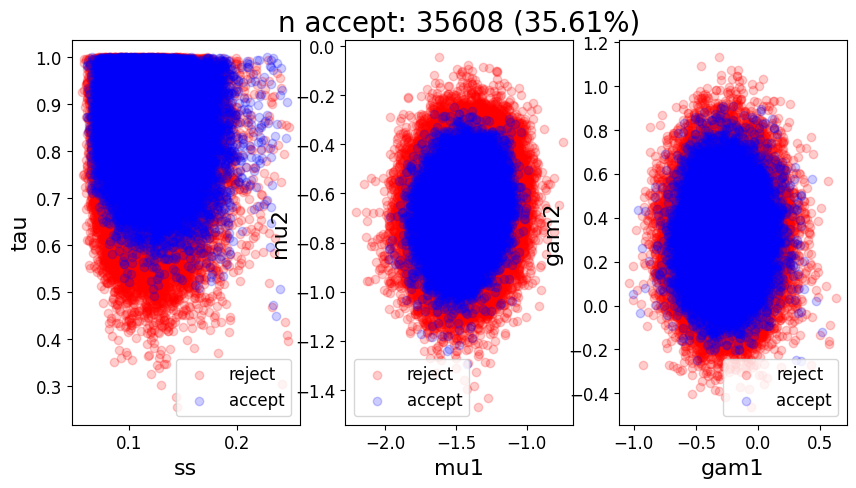

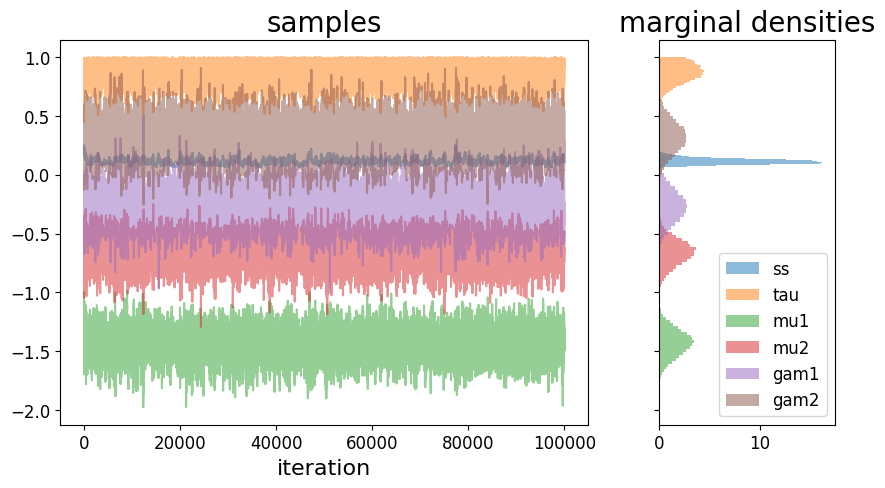

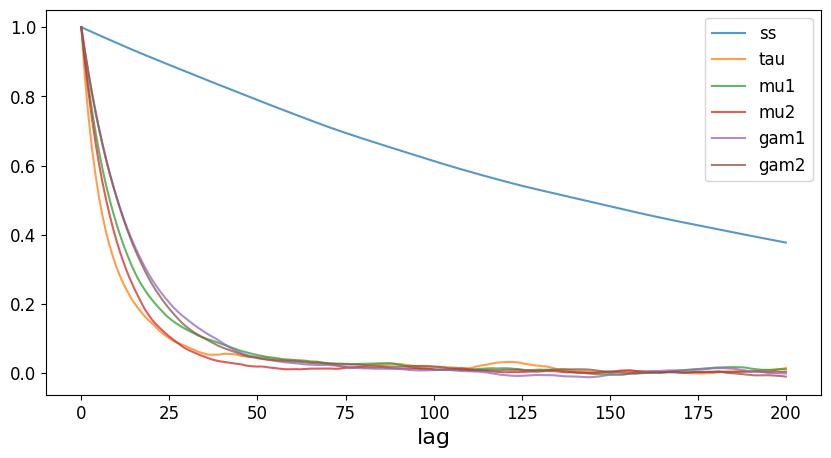

In [156]:
plot_dist(cands_mh, plot_status=True, status=status_mh, fname='mh_dist')
plot_marginals(xt_mh, fname='mh_marg')
plot_acorr(xt_mh, nlags=200, fname='mh_acorr')

In [22]:
# read-out statistics
stats_mh = {}
stats_mh['mean'] = np.mean(xt_mh, axis=0)
stats_mh['var'] = np.var(xt_mh, axis=0)
stats_mh['median'] = np.median(xt_mh, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:
    stats_mh[f'p{pctl}'] = np.percentile(xt_mh, pctl, axis=0)
stats_mh = pd.DataFrame(stats_mh).T
stats_mh.columns = THETA_LABELS
print('univariate statistics')
print(stats_mh.to_latex())

univariate statistics
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
mean   &  0.114662 &  0.861065 & -1.433174 & -0.660694 & -0.267675 &  0.321261 \\
var    &  0.000567 &  0.006893 &  0.014490 &  0.012879 &  0.021396 &  0.021500 \\
median &  0.112433 &  0.867656 & -1.428254 & -0.656396 & -0.268092 &  0.320839 \\
p0     &  0.060772 &  0.448267 & -1.976549 & -1.293310 & -1.003121 & -0.253334 \\
p10    &  0.086091 &  0.748209 & -1.588632 & -0.806830 & -0.453315 &  0.135793 \\
p25    &  0.097034 &  0.806306 & -1.510774 & -0.733144 & -0.365632 &  0.223992 \\
p50    &  0.112433 &  0.867656 & -1.428254 & -0.656396 & -0.268092 &  0.320839 \\
p75    &  0.129463 &  0.926575 & -1.351379 & -0.583359 & -0.172309 &  0.417473 \\
p90    &  0.145588 &  0.967025 & -1.282541 & -0.518370 & -0.083522 &  0.508537 \\
p100   &  0.250000 &  0.999952 & -0.988145 & -0.248247 &  0.511373 &  0.908794 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/1123338245.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_mh.to_latex())


In [23]:
# covariance
cov_mh = pd.DataFrame(np.cov(xt_mh.T))
cov_mh.columns = THETA_LABELS
cov_mh.index = THETA_LABELS
print('covariance')
print(cov_mh.to_latex())

covariance
\begin{tabular}{lrrrrrr}
\toprule
{} &            ss &       tau &       mu1 &       mu2 &          gam1 &      gam2 \\
\midrule
ss   &  5.665551e-04 & -0.000207 & -0.000132 & -0.000188 & -5.061010e-07 &  0.000034 \\
tau  & -2.073358e-04 &  0.006893 &  0.004768 &  0.003428 & -8.462642e-04 &  0.000349 \\
mu1  & -1.323415e-04 &  0.004768 &  0.014490 &  0.002596 & -5.976733e-03 & -0.000114 \\
mu2  & -1.884374e-04 &  0.003428 &  0.002596 &  0.012879 & -4.772910e-04 & -0.005049 \\
gam1 & -5.061010e-07 & -0.000846 & -0.005977 & -0.000477 &  2.139593e-02 & -0.000003 \\
gam2 &  3.384916e-05 &  0.000349 & -0.000114 & -0.005049 & -3.125581e-06 &  0.021501 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/2971513399.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cov_mh.to_latex())


# Gibs sampling

In [37]:
T = 100000
xt_g = []
continuous_scan = True
cond_dists = [val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam]

# Initialize then iterate
x0 = np.array((0.1, 0.75, np.array([0,0]), np.array([0,0])), dtype=object)
x = x0

for t in tqdm(range(T)):
    # sample iteratively from conditional distributions
    # determine scan
    if continuous_scan:
        update_idx = np.array(range(4))
    else:
        update_idx = np.random.choice(range(4), 4, replace=False)
    
    for j in update_idx:
        x[j] = cond_dists[j](x, Y.detach().numpy(), groups)
    
    # record in flattened state
    xt_g += [np.hstack(x)]

xt_g = np.array(xt_g)

100%|█████████████████████████████████| 100000/100000 [01:37<00:00, 1021.31it/s]


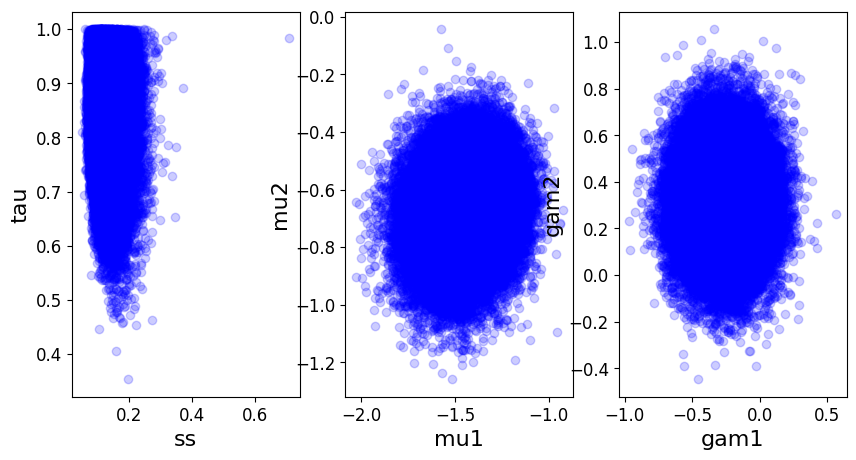

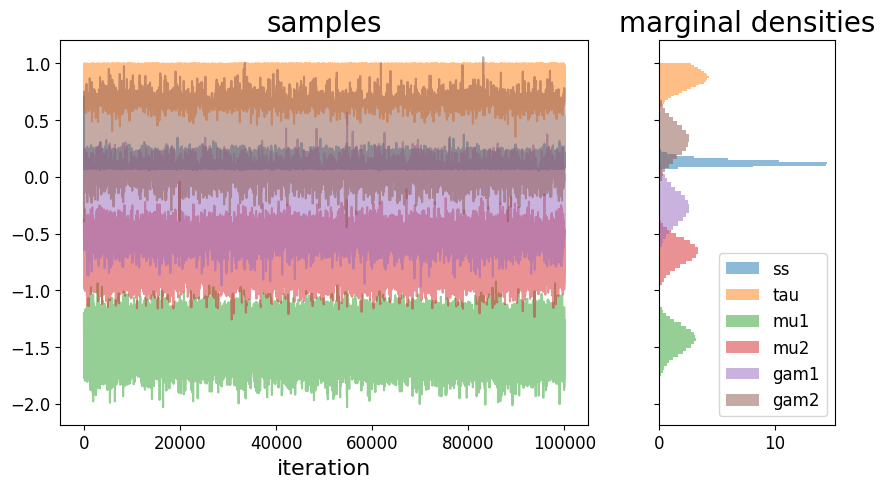

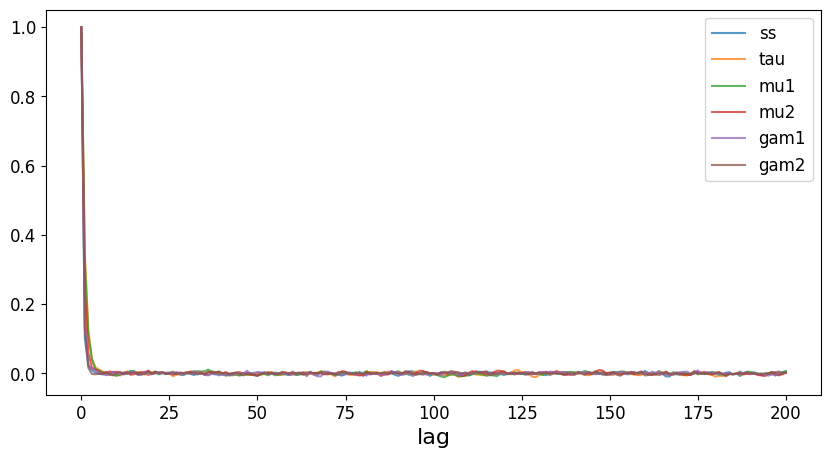

In [38]:
plot_dist(xt_g, plot_status=False, fname='gibbs_dist')
plot_marginals(xt_g, fname='gibbs_marg')
plot_acorr(xt_g, nlags=200, fname='gibbs_acorr')

In [39]:
# read-out statistics
stats_g = {}
stats_g['mean'] = np.mean(xt_g, axis=0)
stats_g['var'] = np.var(xt_g, axis=0)
stats_g['median'] = np.median(xt_g, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:
    stats_g[f'p{pctl}'] = np.percentile(xt_g, pctl, axis=0)
stats_g = pd.DataFrame(stats_g).T
stats_g.columns = THETA_LABELS
print('univariate statistics')
print(stats_mh.to_latex())

univariate statistics
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
mean   &  0.114662 &  0.861065 & -1.433174 & -0.660694 & -0.267675 &  0.321261 \\
var    &  0.000567 &  0.006893 &  0.014490 &  0.012879 &  0.021396 &  0.021500 \\
median &  0.112433 &  0.867656 & -1.428254 & -0.656396 & -0.268092 &  0.320839 \\
p0     &  0.060772 &  0.448267 & -1.976549 & -1.293310 & -1.003121 & -0.253334 \\
p10    &  0.086091 &  0.748209 & -1.588632 & -0.806830 & -0.453315 &  0.135793 \\
p25    &  0.097034 &  0.806306 & -1.510774 & -0.733144 & -0.365632 &  0.223992 \\
p50    &  0.112433 &  0.867656 & -1.428254 & -0.656396 & -0.268092 &  0.320839 \\
p75    &  0.129463 &  0.926575 & -1.351379 & -0.583359 & -0.172309 &  0.417473 \\
p90    &  0.145588 &  0.967025 & -1.282541 & -0.518370 & -0.083522 &  0.508537 \\
p100   &  0.250000 &  0.999952 & -0.988145 & -0.248247 &  0.511373 &  0.908794 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/1753597990.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_mh.to_latex())


In [40]:
# covariance
cov_g = pd.DataFrame(np.cov(xt_g.T))
cov_g.columns = THETA_LABELS
cov_g.index = THETA_LABELS
print('covariance')
print(cov_g.to_latex())

covariance
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
ss   &  0.000826 & -0.000249 & -0.000147 & -0.000092 & -0.000031 & -0.000055 \\
tau  & -0.000249 &  0.007463 &  0.005164 &  0.003526 & -0.000587 &  0.000784 \\
mu1  & -0.000147 &  0.005164 &  0.015991 &  0.002431 & -0.006403 &  0.000453 \\
mu2  & -0.000092 &  0.003526 &  0.002431 &  0.014178 & -0.000325 & -0.005653 \\
gam1 & -0.000031 & -0.000587 & -0.006403 & -0.000325 &  0.023484 &  0.000019 \\
gam2 & -0.000055 &  0.000784 &  0.000453 & -0.005653 &  0.000019 &  0.023579 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/2606517917.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cov_g.to_latex())


# Hamiltonian Monte Carlo

### Grid search

In [74]:
# vary variances of proposal distributions to i) increase acceptance probability and ii) decrease acorr
q0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
scale = 1000 # used to implement boundary constraint on sigma and tau
T = 500 # iterations for grid search
burn_in = 0
acorr_threshold = 0.5
steps_threshold = 75
report_hmc = {}
best_accept_hmc = 0.0

# hyperparameter grid
M_rats = [
#     [1, 1, 1, 1, 1, 1],
#       [0.5, 1, 1, 1, 1, 1],
      [0.25, 0.5, 1, 1, 1, 1],
#       [0.25, 0.5, 1, 1, 0.75, 0.75]
]
M_scales = [1, 1.5, 2]
Ls = [5, 10, 20]
epss = [0.01, 0.001, 0.0001]
best_params_hmc = (M_rats[0], M_scales[0], Ls[0], epss[0])

In [75]:
# search hyperparameter space
for i, M_rat in enumerate(tqdm(M_rats, disable=False)):
    for M_scale in M_scales:
        M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
        M_inv = torch.linalg.inv(M)
        p0 = torch.tensor(sps.multivariate_normal.rvs(mean=np.repeat(0,len(q0)), cov=M)).float()
        for L in Ls:
            for eps in epss:
#                 print('running:', M_rat, M_scale, L, eps)
                # run MH
                qt, cands, status = HMC(q=q0, p=p0, Y=Y, groups=groups, M=M, M_inv=M_inv, 
                                        eps=eps, L=L, T=T, verbose=False)
                # get and log stats
                pct_accept = np.sum(status == 'a') / len(status)
#                 lags = np.apply_along_axis(sm.tsa.acf, axis=0, arr=qt, nlags=T/10)
#                 max_steps = 0
#                 for i in range(lags.shape[1]):
#                     max_steps = np.maximum(max_steps, np.min(np.where(lags[:,i] < acorr_threshold)))
                report_hmc[i, M_scale, L, eps] = [pct_accept]
                
                # remember best
                if (pct_accept > best_accept_hmc):
                    best_accept_hmc = pct_accept
                    best_params_hmc = (M_rat, M_scale, L, eps)

print('best parameters (Mrat, Mscale, L, eps):', best_params_hmc)

100%|████████████████████████████████████████████| 1/1 [04:35<00:00, 275.92s/it]

best parameters (Mrat, Mscale, L, eps): ([0.25, 0.5, 1, 1, 1, 1], 1.5, 20, 0.0001)


In [76]:
report_hmc_pd = pd.DataFrame(report_hmc).T
report_hmc_pd = report_hmc_pd.reset_index()
report_hmc_pd.columns = ['M ratios', 'M scale', 'L', 'epsilon', 'Acceptance rate']

print(report_hmc_pd.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 M ratios &  M scale &  L &  epsilon &  Acceptance rate \\
\midrule
        0 &      1.0 &  5 &   0.0100 &            0.242 \\
        0 &      1.0 &  5 &   0.0010 &            0.376 \\
        0 &      1.0 &  5 &   0.0001 &            0.412 \\
        0 &      1.0 & 10 &   0.0100 &            0.052 \\
        0 &      1.0 & 10 &   0.0010 &            0.442 \\
        0 &      1.0 & 10 &   0.0001 &            0.374 \\
        0 &      1.0 & 20 &   0.0100 &            0.002 \\
        0 &      1.0 & 20 &   0.0010 &            0.298 \\
        0 &      1.0 & 20 &   0.0001 &            0.400 \\
        0 &      1.5 &  5 &   0.0100 &            0.278 \\
        0 &      1.5 &  5 &   0.0010 &            0.424 \\
        0 &      1.5 &  5 &   0.0001 &            0.432 \\
        0 &      1.5 & 10 &   0.0100 &            0.202 \\
        0 &      1.5 & 10 &   0.0010 &            0.350 \\
        0 &      1.5 & 10 &   0.0001 &            0.386 \\
        0 &    

/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/109306810.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(report_hmc_pd.to_latex(index=False))


### Run with best hyperparams

In [79]:
# best parameters
T=1000
M_rat, M_scale, L, eps = best_params_hmc
M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
M_inv = torch.linalg.inv(M)

In [95]:
# toy parameters
T=100000
M_rat, M_scale, L, eps = ([0.25, 0.5, 1, 1, 1, 1], 1.5, 10, 0.0025)
M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
M_inv = torch.linalg.inv(M)

In [96]:
q0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0], dtype=torch.float)
p0 = torch.tensor(sps.multivariate_normal.rvs(mean=np.repeat(0,len(q0)), cov=M)).float()
q_hmc, cands_hmc, status_hmc = HMC(q0, p0, Y, groups, M, M_inv, eps, L, T)

100%|███████████████████████████████████| 100000/100000 [30:53<00:00, 53.95it/s]


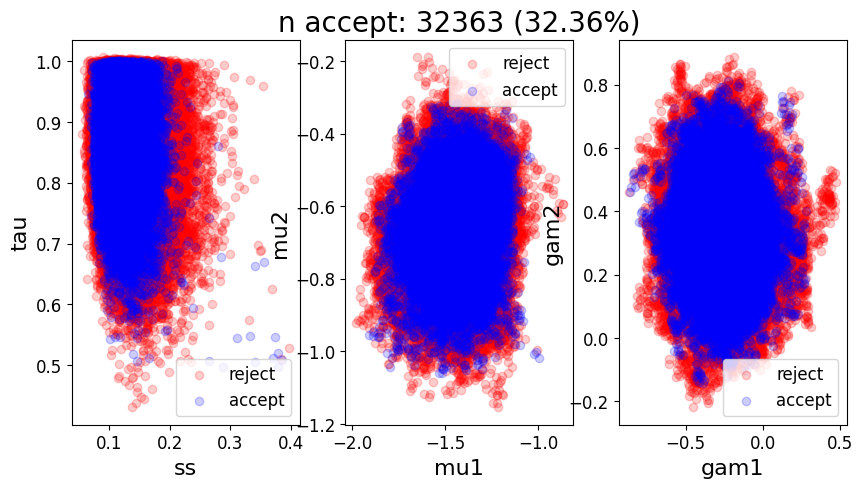

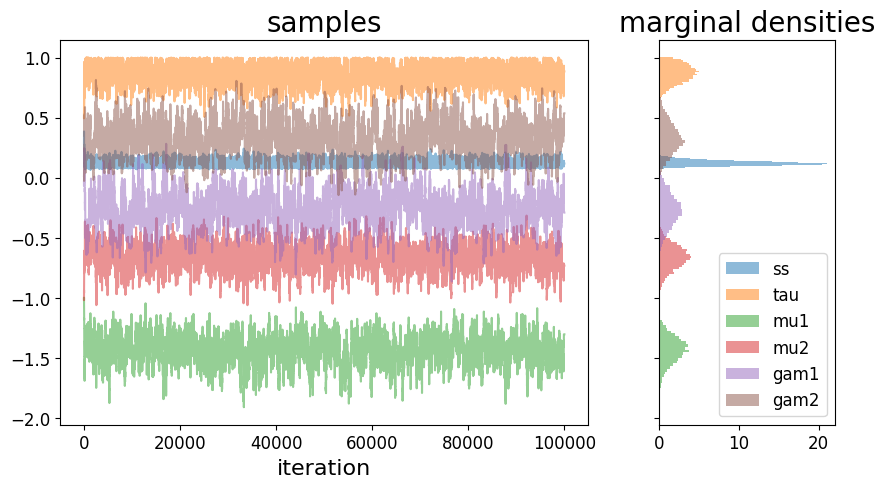

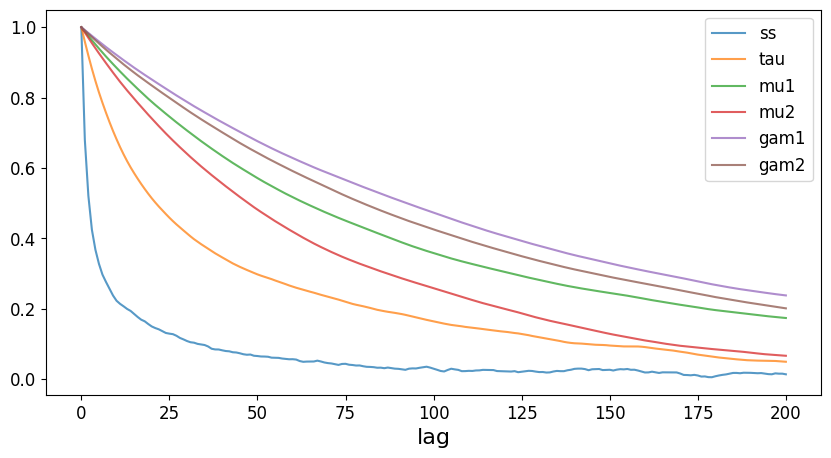

In [97]:
plot_dist(cands_hmc, plot_status=True, status=status_hmc, fname='hmc_dist')
plot_marginals(q_hmc, fname='hmc_marg')
plot_acorr(q_hmc, nlags=200, fname='hmc_acorr')

In [99]:
# read-out statistics
stats_hmc = {}
stats_hmc['mean'] = np.mean(q_hmc, axis=0)
stats_hmc['var'] = np.var(q_hmc, axis=0)
stats_hmc['median'] = np.median(q_hmc, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:
    stats_hmc[f'p{pctl}'] = np.percentile(q_hmc, pctl, axis=0)
stats_hmc = pd.DataFrame(stats_hmc).T
stats_hmc.columns = THETA_LABELS
print('univariate statistics')
print(stats_hmc.to_latex())

univariate statistics
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
mean   &  0.120568 &  0.863886 & -1.433177 & -0.662749 & -0.268818 &  0.329712 \\
var    &  0.000406 &  0.006003 &  0.013752 &  0.011229 &  0.021705 &  0.019261 \\
median &  0.118352 &  0.869840 & -1.427280 & -0.659320 & -0.269174 &  0.323608 \\
p0     &  0.065007 &  0.495930 & -1.908123 & -1.059554 & -0.862452 & -0.143813 \\
p10    &  0.096797 &  0.760097 & -1.585403 & -0.799194 & -0.457929 &  0.154746 \\
p25    &  0.106273 &  0.810910 & -1.507754 & -0.730388 & -0.364532 &  0.237090 \\
p50    &  0.118352 &  0.869840 & -1.427280 & -0.659320 & -0.269174 &  0.323608 \\
p75    &  0.132432 &  0.924183 & -1.352740 & -0.591091 & -0.174501 &  0.421964 \\
p90    &  0.147103 &  0.963355 & -1.289032 & -0.530516 & -0.082192 &  0.517047 \\
p100   &  0.385267 &  1.002555 & -0.997103 & -0.314419 &  0.282297 &  0.813231 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/2729791038.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_hmc.to_latex())


In [100]:
# covariance
cov_hmc = pd.DataFrame(np.cov(q_hmc.T))
cov_hmc.columns = THETA_LABELS
cov_hmc.index = THETA_LABELS
print('covariance')
print(cov_hmc.to_latex())

covariance
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
ss   &  0.000406 & -0.000174 & -0.000109 & -0.000148 & -0.000030 &  0.000069 \\
tau  & -0.000174 &  0.006003 &  0.004706 &  0.003352 & -0.000798 &  0.000399 \\
mu1  & -0.000109 &  0.004706 &  0.013752 &  0.001797 & -0.006199 &  0.001104 \\
mu2  & -0.000148 &  0.003352 &  0.001797 &  0.011230 & -0.000166 & -0.005065 \\
gam1 & -0.000030 & -0.000798 & -0.006199 & -0.000166 &  0.021706 & -0.000984 \\
gam2 &  0.000069 &  0.000399 &  0.001104 & -0.005065 & -0.000984 &  0.019261 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/1772880878.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cov_hmc.to_latex())


# Importance sampling

In [101]:
T = 100000
theta = torch.tensor([val_is_cand(Y, groups) for i in tqdm(range(T))])
u = torch.tensor([weight_is_cand(theta=theta[i,:], Y=Y, groups=groups) for i in range(theta.shape[0])])
w = u / torch.sum(u)
theta_hat = theta * np.reshape(w, (w.shape[0],1))

100%|█████████████████████████████████| 100000/100000 [01:08<00:00, 1454.23it/s]


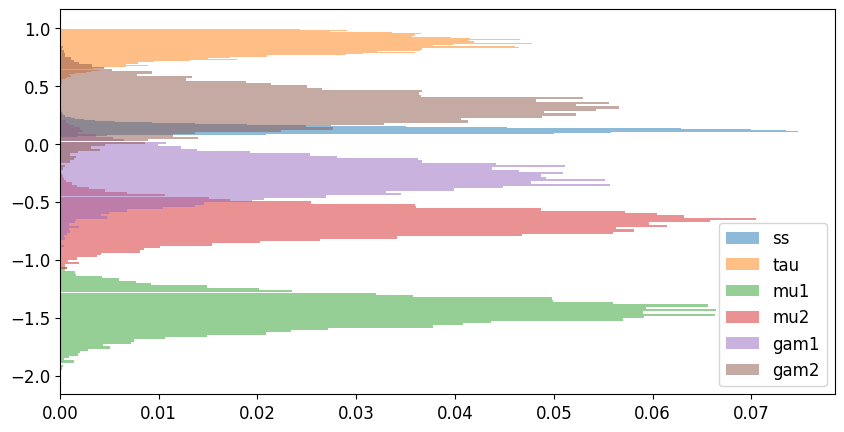

In [47]:
# histogram
n = 100
bins = torch.stack([
    torch.linspace(0, 0.5, n),
    torch.linspace(0, 1, n),
    torch.linspace(-2, 0, n),
    torch.linspace(-2, 0, n),
    torch.linspace(-1, 1, n),
    torch.linspace(-1, 1, n)]).T
i = 10
j = 2

vals = np.zeros([n, theta.shape[1]])
for j in range(theta.shape[1]):
    for i in range(n-1):
        vals[i,j] += [torch.sum(((theta[:,j] >= bins[i,j]) & (theta[:,j] < bins[i+1,j])*1).float() * w).detach().numpy()]

        
fig, ax = plt.subplots(figsize=(10, 5))
for j in range(bins.shape[1]):
    plt.barh(y=bins[:,j], width=vals[:,j], height=(bins[:,j].max() - bins[:,j].min())/n, alpha=0.5, label=THETA_LABELS[j])
    
plt.legend()
plt.savefig(fname=f'{RESULTS_PATH}is_marg.png', bbox_inches='tight')
plt.show()

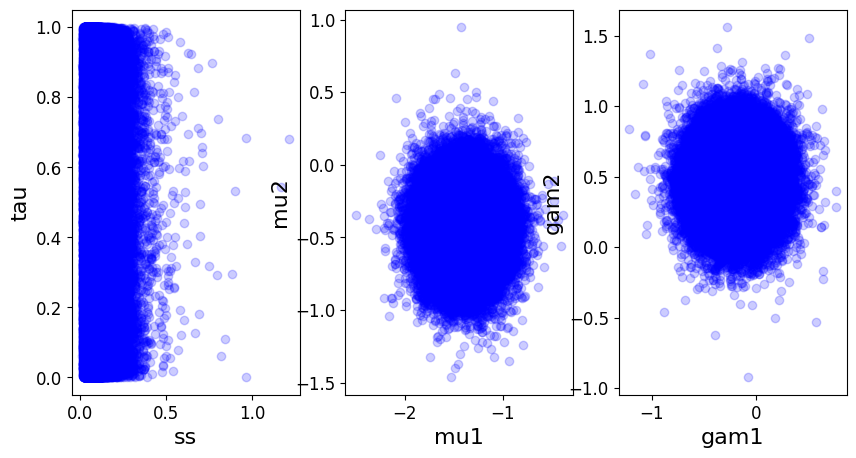

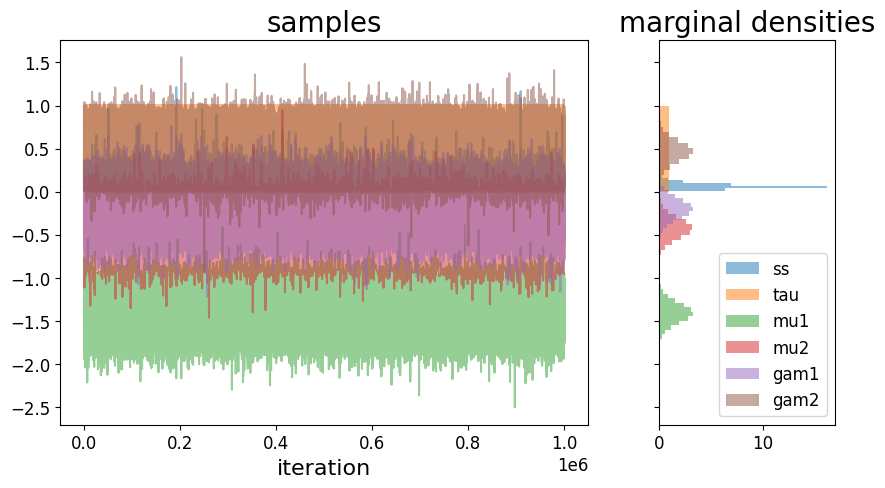

In [44]:
plot_dist(theta, plot_status=False, fname='is_c_dist')
plot_marginals(theta, fname='is_c_marg')

In [102]:
# read-out statistics
stats_is = {}
stats_is['mean'] = torch.sum(theta_hat, axis=0)
stats_is['var'] = torch.sum(torch.square(theta - torch.mean(theta, axis=0)) * torch.reshape(w, (w.shape[0],1)), axis=0)
stats_is = pd.DataFrame(stats_is).T
stats_is.columns = THETA_LABELS
print('univariate statistics')
print(stats_is.to_latex())

univariate statistics
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
mean &  0.127053 &  0.850954 & -1.438831 & -0.663804 & -0.262994 &  0.322258 \\
var  &  0.004413 &  0.131497 &  0.018104 &  0.072521 &  0.028709 &  0.044306 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/251293536.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_is.to_latex())


In [103]:
# covariance
cov_is = torch.zeros((theta.shape[1], theta.shape[1]))

for i in range(theta.shape[1]):
    for j in range(theta.shape[1]):
        cov_is[i,j] = torch.sum(((theta[:,i] - torch.mean(theta[:,i])) * (theta[:,j] - torch.mean(theta[:,j]))) * w)

        
cov_is = pd.DataFrame(cov_is.numpy())
cov_is.columns = THETA_LABELS
cov_is.index = THETA_LABELS
print('covariance')
print(cov_is.to_latex())

covariance
\begin{tabular}{lrrrrrr}
\toprule
{} &        ss &       tau &       mu1 &       mu2 &      gam1 &      gam2 \\
\midrule
ss   &  0.004413 &  0.020924 & -0.002312 & -0.014642 & -0.004114 & -0.009005 \\
tau  &  0.020924 &  0.131497 & -0.006785 & -0.080570 & -0.023981 & -0.050605 \\
mu1  & -0.002312 & -0.006785 &  0.018104 &  0.011571 & -0.004222 &  0.007365 \\
mu2  & -0.014642 & -0.080570 &  0.011571 &  0.072521 &  0.015100 &  0.030857 \\
gam1 & -0.004114 & -0.023981 & -0.004222 &  0.015100 &  0.028709 &  0.007009 \\
gam2 & -0.009005 & -0.050605 &  0.007365 &  0.030857 &  0.007009 &  0.044306 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/2129302947.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cov_is.to_latex())


## Final table

In [149]:
stats_mh_f = stats_mh.T.reset_index()
stats_mh_f['method'] = '1. Metropolis-Hasting'
stats_mh_f['baccept'] = np.sum(status_mh == 'a') / len(status_mh)
stats_mh_f['acorr'] = 'high'
stats_mh_f['time'] = '03:32'

stats_g_f = stats_g.T.reset_index()
stats_g_f['method'] = '2. Gibbs Sampling'
stats_g_f['baccept'] = 1
stats_g_f['acorr'] = 'low'
stats_g_f['time'] = '01:37'

stats_hmc_f = stats_hmc.T.reset_index()
stats_hmc_f['method'] = '3. Hamiltonian Monte Carlo'
stats_hmc_f['baccept'] = np.sum(status_hmc == 'a') / len(status_hmc)
stats_hmc_f['acorr'] = 'low'
stats_hmc_f['time'] = '30.53'

stats_is_f = stats_is.T.reset_index()
stats_is_f['method'] = '4. Importance Sampling'
stats_is_f['baccept'] = None
stats_is_f['acorr'] = None
stats_is_f['time'] = '01:08'

stats_f = pd.concat([stats_mh_f, stats_g_f, stats_hmc_f, stats_is_f], axis=0).rename(columns={'index':'theta'})

In [151]:
# print theta-level stats
print(stats_f[['method', 'theta', 'mean', 'var', 'p0', 'p50', 'p100']].sort_values(by=['theta', 'method']).to_latex(index=False))

\begin{tabular}{llrrrrr}
\toprule
                    method & theta &      mean &      var &        p0 &       p50 &      p100 \\
\midrule
     1. Metropolis-Hasting &  gam1 & -0.267675 & 0.021396 & -1.003121 & -0.268092 &  0.511373 \\
         2. Gibbs Sampling &  gam1 & -0.268469 & 0.023484 & -0.967721 & -0.268257 &  0.565895 \\
3. Hamiltonian Monte Carlo &  gam1 & -0.268818 & 0.021705 & -0.862452 & -0.269174 &  0.282297 \\
    4. Importance Sampling &  gam1 & -0.262994 & 0.028709 &       NaN &       NaN &       NaN \\
     1. Metropolis-Hasting &  gam2 &  0.321261 & 0.021500 & -0.253334 &  0.320839 &  0.908794 \\
         2. Gibbs Sampling &  gam2 &  0.321858 & 0.023579 & -0.447171 &  0.321986 &  1.055153 \\
3. Hamiltonian Monte Carlo &  gam2 &  0.329712 & 0.019261 & -0.143813 &  0.323608 &  0.813231 \\
    4. Importance Sampling &  gam2 &  0.322258 & 0.044306 &       NaN &       NaN &       NaN \\
     1. Metropolis-Hasting &   mu1 & -1.433174 & 0.014490 & -1.976549 & -1.428254 & 

/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/1392891333.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_f[['method', 'theta', 'mean', 'var', 'p0', 'p50', 'p100']].sort_values(by=['theta', 'method']).to_latex(index=False))


In [154]:
# print report-level stats
print(stats_f[['method', 'baccept', 'acorr',  'time']].drop_duplicates().to_latex(index=False))


\begin{tabular}{lrll}
\toprule
                    method &  baccept & acorr &  time \\
\midrule
     1. Metropolis-Hasting &  0.35608 &  high & 03:32 \\
         2. Gibbs Sampling &  1.00000 &   low & 01:37 \\
3. Hamiltonian Monte Carlo &  0.32363 &   low & 30.53 \\
    4. Importance Sampling &      NaN &  None & 01:08 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_4341/3125967542.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_f[['method', 'baccept', 'acorr',  'time']].drop_duplicates().to_latex(index=False))
